In [ ]:
import os
import sys

path_to_project = os.path.dirname(os.path.abspath("")) + "/"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("decision-focused-learning-codebase"))))

### First, we need the data.

By default, there are two different ways to obtain data -- generate it on the fly or load from a `.pkl` file.
In this notebook, we follow the latter approach.


In [ ]:
from src import get_data
from src.registries.data import data_registry
from src.utils.load import print_registry

# Look at implemented functions that generate/load the data
print_registry(data_registry)

In [ ]:
# Note that the 'get_data' function returns two outputs (the second one is not relevant here)
# In this notebook, we use a simple knapsack problem.
data_dict, _ = get_data(
    name="knapsack_pyepo",
)
print()
print(data_dict.keys())

### Second, we describe the underlying constrained optimization model.
The main way to create optimization models is via the `make_model` function. `make_model` can only create models that were previously registered.

In [ ]:
from src.registries.models import model_registry

# Models with prefix `cvxpy` will use differentiable `cvxpy_` solver while `gbpy_` will use non-differentiable Guroby.
print_registry(model_registry, filter_word="knapsack")

In [ ]:
from src import make_model

# We will use the cvxpy_ version as it is differentiable and fits better our continuous case.
model_name = "cvxpy_knapsack_pyepo"
model, params = make_model(name=model_name)
# `params` dict contains parameter values used to create optimmization model.
print(params)

In [ ]:
# Entries in `params` can be overriden
model, params = make_model(name=model_name, capacity=10)
print(params)

In [ ]:
# In our implementation, knapsack is a maximization problem
model.model_sense_int, model.model_sense

### Third, we combine data and optimizatoin model to create an instance of DFL Problem.

In [ ]:
from src.problem import Problem

# Problem contains data, implementes train/val/test splitting, and allows efficient sampling.
problem = Problem(
    data_dict=data_dict,
    opt_model=model,
    train_ratio=0.7,
    val_ratio=0.15,
    compute_optimal_decisions=True,
    compute_optimal_objectives=True,
    standardize_features=False,
    time_respecting_split=True,
    seed=42,
)

In [ ]:
# For example, we can set the mode (from ['train', 'val', 'test']) and then sample a batch
problem.set_mode("train")
b_inds = problem.generate_batch_indices(batch_size=2)
for inds in b_inds:
    b_data = problem.read_data(inds)
    break
b_data

### Now, we can choose a solution method and solve the DFL problem
In our codebase, algorithms are implemented via the DecisionMaker class.

We begin by usins a simple `DifferentiableDecisionMaker`, which will use differentiability of the CVXPY Layers problems.

In [ ]:
from src.decision_makers import DifferentiableDecisionMaker

decision_maker = DifferentiableDecisionMaker(
    problem=problem,
    learning_rate=1e-3,
    batch_size=64,
    device_str="cpu",
    predictor_str="MLP",
    decision_model_str="base",
    loss_function_str="objective",
)

In [ ]:
problem.dataset[4]

In [ ]:
from src.runner import Runner

# We are ready to run the training. We use `runner` to wrap everything together and run the experiments.
runner = Runner(
    decision_maker=decision_maker,
    num_epochs=10,
    experiments_folder="results/",
    main_metric="abs_regret",
    store_min_and_max=False,
    use_wandb=False,
    experiment_name="test_experiment",
    project_name="test_project",
    early_stop=False,
    min_delta_early_stop=None,
    patience_early_stop=None,
    save_best=True,
    seed=None,
    config=None,
)

runner.run()

NameError: name 'runner' is not defined

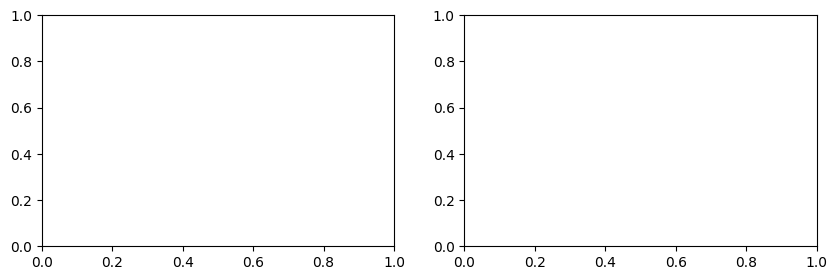

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metric = "train/objective_mean"
_ = axs[0].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[0].set_title(metric)

metric = "validation/objective_mean"
_ = axs[1].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[1].set_title(metric)